In [9]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

In [10]:
# case can be "rgb_rad, rgb_angle, depth_rad or depth_angle"

case = 'rgb_rad'

ves = 3

In [11]:
if case.split('_')[1] == 'rad':
        classes_num = 6
elif case.split('_')[1] == 'angle':
        classes_num = 16
else:
        print ('error "case" not defined')

In [12]:
model = torchvision.models.resnet18(pretrained=True, progress=True)

if case.split('_')[0] == 'depth':
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model.fc = nn.Linear(512, classes_num)
model.eval()

weights = './Weights/' + case + '_v' + str(ves) + '.pth'
model.load_state_dict(torch.load(weights))
cam_extractor = SmoothGradCAMpp(model)

In [13]:
data_dir = './dataset/train/' + case.split('_')[1] + '/' + case.split('_')[0]

if case.split('_')[0] == 'depth':
    test_transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
else:
    test_transform = torchvision.transforms.Compose([transforms.ToTensor()])

ds = ImageFolder(data_dir, transform=test_transform)

train_size = int(0.9985 * len(ds))
test_size = len(ds) - train_size
_, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

In [14]:
def activation_map(img, model, device):
    
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get prediction from model
    yb = model(xb.to(device))
    # Get the normalized probability vector
    activation_map = cam_extractor(yb.squeeze(0).argmax().item(), yb)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    return result

def plot(imgs, case, save=False):
    
    save_path = './results/' + case.split('_')[0] + '_v' + str(ves) + '/'
    name = case.split('_')[1] + ' activation map' + '.png'
    fig, ax = plt.subplots(len(imgs)//3,3, figsize=(15, 15))
    
    for ii in range(len(imgs)//3):
        for jj in range(3):
            ax[ii,jj].imshow(imgs[ii+jj*3])
            ax[ii,jj].set_axis_off()
            
    if save: plt.savefig(os.path.join(save_path, name))
    plt.show()

In [15]:
CAM_images = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for data in test_ds:
    img, _ = data
    activation_img = activation_map(img, model, device)
    CAM_images.append(activation_img)


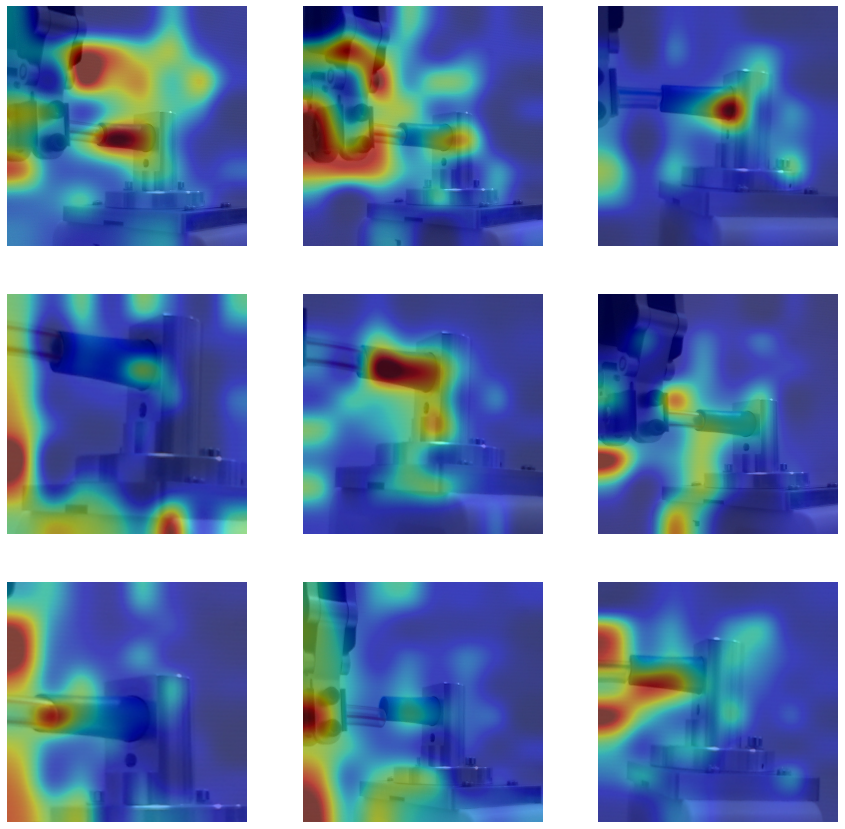

In [16]:
plot(CAM_images, case, save = True)